In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

# 1. Cargar datos
df = pd.read_csv('/content/sample_data/bhs_final.csv', index_col='C1')

# 2. Variables predictoras
predictoras = [
    'D1', 'D2', 'M1', 'M2', 'M3', 'M4', 'A2', 'A4', 'Di1', 'Di3', 'Di4', 'Di7', 'Di9',
    'F1', 'F3', 'F5', 'F7', 'T2', 'Al22', 'Dr7', 'H1', 'H2', 'H3', 'H4', 'H18', 'H19',
    'TE10', 'TE5', 'TE6', 'TE7', 'TE9', 'Tr1', 'Tr10', 'Tr5', 'Tr7', 'Tr8', 'Tr9',
    'Amb1', 'Amb2', 'Amb3', 'Amb4', 'Amb5', 'Amb6', 'Amb7', 'Amb8', 'Amb9', 'Amb10',
    'Amb11', 'Amb12', 'Amb13', 'Amb14', 'Amb15'
]

# 3. Variables objetivo
objetivos = [f'Sa{i}' for i in range(1, 9)]

# 4. Umbral personalizado
umbral = 0.3

# 5. Repeticiones
N = 10

for objetivo in objetivos:
    print(f"\n📌 Clasificación para {objetivo}")
    df_filtrado = df.dropna(subset=[objetivo])

    clases = df_filtrado[objetivo].unique()
    if len(clases) < 2:
        print(f"⚠️  Solo hay una clase presente en {objetivo}. Se omite.")
        continue

    accs, precs, recs, f1s = [], [], [], []
    coefs = []

    for seed in range(N):
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(df_filtrado[predictoras])
        y = df_filtrado[objetivo].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )

        model = LogisticRegressionCV(
            Cs=10,
            cv=5,
            penalty='l1',
            solver='saga',
            max_iter=10000,
            scoring='f1',
            random_state=seed
        )
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > umbral).astype(int)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        coefs.append(model.coef_.ravel())

    def resumen(m):
        arr = np.array(m)
        media = np.mean(arr)
        std = np.std(arr, ddof=1)
        ci = stats.t.interval(0.95, len(arr)-1, loc=media, scale=std/np.sqrt(len(arr)))
        return media, std, ci

    acc_mu, acc_std, acc_ci = resumen(accs)
    prec_mu, prec_std, prec_ci = resumen(precs)
    rec_mu, rec_std, rec_ci = resumen(recs)
    f1_mu, f1_std, f1_ci = resumen(f1s)

    print(f"✅ Accuracy: {acc_mu:.4f} ± {acc_std:.4f} [95% CI: {acc_ci[0]:.4f}, {acc_ci[1]:.4f}]")
    print(f"🎯 Precision: {prec_mu:.4f} ± {prec_std:.4f} [95% CI: {prec_ci[0]:.4f}, {prec_ci[1]:.4f}]")
    print(f"📈 Recall: {rec_mu:.4f} ± {rec_std:.4f} [95% CI: {rec_ci[0]:.4f}, {rec_ci[1]:.4f}]")
    print(f"🏆 F1-score: {f1_mu:.4f} ± {f1_std:.4f} [95% CI: {f1_ci[0]:.4f}, {f1_ci[1]:.4f}]")

    # Análisis de coeficientes
    coef_mean = np.mean(coefs, axis=0)
    coef_series = pd.Series(coef_mean, index=predictoras)
    importantes = coef_series[coef_series.abs() > 0.01].sort_values(key=abs, ascending=False)

    if importantes.empty:
        print("⚠️  Ninguna variable tiene peso significativo (> 0.01).")
    else:
        print("\n🌟 Variables más influyentes (promedio de coeficientes):")
        print(importantes)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')
        plt.title(f'Coeficientes medios significativos para {objetivo}')
        plt.xlabel('Valor promedio del coeficiente')
        plt.tight_layout()
        plt.savefig(f'importantes_{objetivo}.png')
        plt.close()



📌 Clasificación para Sa1
✅ Accuracy: 0.7215 ± 0.0087 [95% CI: 0.7153, 0.7278]
🎯 Precision: 0.5694 ± 0.0106 [95% CI: 0.5618, 0.5770]
📈 Recall: 0.7646 ± 0.0165 [95% CI: 0.7528, 0.7764]
🏆 F1-score: 0.6526 ± 0.0097 [95% CI: 0.6456, 0.6595]

🌟 Variables más influyentes (promedio de coeficientes):
D2       0.768348
M1       0.455011
Tr9      0.397500
Tr5     -0.261218
Tr7     -0.244230
TE10    -0.234655
TE5      0.205333
M4       0.198421
M3       0.184387
H18      0.170048
TE9      0.161823
H19      0.160868
Amb9     0.151310
Amb8    -0.143578
Dr7      0.132812
D1       0.128128
TE6     -0.104005
Amb1    -0.097968
Di7      0.093579
H1       0.089501
Di9      0.083981
H2      -0.083027
F5      -0.081423
Di3     -0.073000
F7      -0.060877
Di1      0.054167
Amb11    0.052059
Tr1      0.046328
A2      -0.042452
Amb3    -0.036836
A4      -0.036741
M2      -0.033549
Tr10     0.033278
Amb14   -0.032783
Amb2     0.031511
Amb7    -0.028452
Amb4     0.026926
Amb10   -0.022916
F3      -0.019465
Amb1

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa2
✅ Accuracy: 0.6517 ± 0.0116 [95% CI: 0.6435, 0.6600]
🎯 Precision: 0.5078 ± 0.0112 [95% CI: 0.4998, 0.5158]
📈 Recall: 0.7470 ± 0.0242 [95% CI: 0.7297, 0.7643]
🏆 F1-score: 0.6044 ± 0.0119 [95% CI: 0.5959, 0.6130]

🌟 Variables más influyentes (promedio de coeficientes):
D1       0.580735
D2       0.457753
M3       0.456999
M1       0.368465
H19      0.318989
TE9      0.265308
Tr9      0.238034
F5      -0.184984
TE5      0.180133
Di1      0.178241
A2      -0.155071
M2       0.146742
Tr7     -0.125181
Amb11   -0.112352
Amb4     0.111132
Amb13   -0.097350
TE10    -0.092961
F1      -0.091768
H18      0.091560
Al22     0.091203
Amb8    -0.089144
H1       0.086466
Tr10     0.077022
Di9      0.073812
H4       0.073617
Amb14   -0.071410
F3      -0.070077
Amb3    -0.063823
Tr5     -0.053752
TE7      0.049201
H2      -0.046562
A4      -0.045961
Di7     -0.044811
Tr1     -0.036789
M4       0.033002
Di4      0.031843
Amb10    0.030638
Tr8     -0.027346
Amb7    -0.027304
Amb1

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa3
✅ Accuracy: 0.9008 ± 0.0029 [95% CI: 0.8988, 0.9029]
🎯 Precision: 0.0158 ± 0.0499 [95% CI: -0.0199, 0.0515]
📈 Recall: 0.0022 ± 0.0068 [95% CI: -0.0027, 0.0070]
🏆 F1-score: 0.0038 ± 0.0120 [95% CI: -0.0048, 0.0124]

🌟 Variables más influyentes (promedio de coeficientes):
M3       0.057703
H19      0.045884
TE10    -0.043301
Amb11    0.034324
Tr5      0.030335
Dr7      0.028154
M1       0.027312
M4       0.025022
TE9      0.024894
Amb10    0.022063
Tr9     -0.020373
Tr7      0.019556
TE5      0.017393
Amb13    0.017205
F5      -0.016248
Amb3    -0.015962
Amb5    -0.012892
dtype: float64


<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa4
✅ Accuracy: 0.5679 ± 0.0138 [95% CI: 0.5580, 0.5778]
🎯 Precision: 0.5376 ± 0.0089 [95% CI: 0.5312, 0.5439]
📈 Recall: 0.9141 ± 0.0204 [95% CI: 0.8996, 0.9287]
🏆 F1-score: 0.6769 ± 0.0075 [95% CI: 0.6715, 0.6822]

🌟 Variables más influyentes (promedio de coeficientes):
M1       0.715526
H19      0.450055
M3       0.400203
M2       0.389956
D1       0.378724
M4       0.333749
TE9      0.254121
D2       0.234498
TE5      0.221547
TE10    -0.166865
Di7      0.135994
H4       0.128532
F5      -0.124579
A4      -0.105776
Tr7      0.100095
Di1      0.090319
Amb4    -0.089102
Dr7      0.077227
Amb2     0.074900
Amb9     0.068522
F3      -0.067893
Tr8      0.057438
F1       0.056549
Amb8    -0.055872
Al22     0.054050
Tr9      0.052565
A2      -0.051350
Amb3    -0.050701
F7      -0.045965
TE7      0.042909
Tr5     -0.039960
Di9      0.038597
Amb7    -0.036148
Amb11   -0.035078
Amb1    -0.026879
Tr1      0.025243
Amb13    0.024720
Amb12    0.024134
Amb5     0.022645
Amb1

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa5
✅ Accuracy: 0.7448 ± 0.0111 [95% CI: 0.7369, 0.7527]
🎯 Precision: 0.5681 ± 0.0143 [95% CI: 0.5579, 0.5784]
📈 Recall: 0.7392 ± 0.0188 [95% CI: 0.7257, 0.7526]
🏆 F1-score: 0.6424 ± 0.0144 [95% CI: 0.6321, 0.6526]

🌟 Variables más influyentes (promedio de coeficientes):
D1       1.185092
Tr9      0.787612
D2       0.575780
H19      0.547689
M3       0.481189
M1       0.455683
M4       0.407757
M2       0.350681
Amb8    -0.308062
Tr7      0.267236
TE5      0.265094
TE9      0.231345
Di1      0.177693
F5      -0.175311
Amb10   -0.154947
Di4     -0.140029
Amb1    -0.133937
Tr5     -0.133437
Amb11    0.121025
H4       0.120796
Tr8      0.118091
F3      -0.116184
A2      -0.103854
F1      -0.100165
TE10    -0.091948
Tr1     -0.086568
H18      0.084764
Dr7     -0.068926
Amb2    -0.067275
Amb13   -0.065404
Amb9     0.065105
Di9     -0.062170
Di7      0.061120
A4      -0.052106
TE7      0.051917
Amb7     0.045332
T2       0.043112
Amb15   -0.038959
Tr10     0.038052
Amb1

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa6
✅ Accuracy: 0.8494 ± 0.0065 [95% CI: 0.8448, 0.8540]
🎯 Precision: 0.6601 ± 0.0175 [95% CI: 0.6476, 0.6726]
📈 Recall: 0.5429 ± 0.0313 [95% CI: 0.5205, 0.5653]
🏆 F1-score: 0.5954 ± 0.0229 [95% CI: 0.5791, 0.6118]

🌟 Variables más influyentes (promedio de coeficientes):
M3       2.530979
M2       1.318652
M4       0.737539
TE5      0.611612
TE9      0.544244
TE10    -0.461215
D1       0.449360
M1       0.406295
Tr7      0.361951
H19      0.331929
Tr9      0.324421
Amb2     0.263116
Amb8    -0.221778
Amb9     0.187927
A2      -0.186562
T2       0.179044
Amb13    0.145142
A4      -0.139925
Amb14   -0.133998
Amb4    -0.132884
Di7      0.129115
Di3     -0.110384
Amb10   -0.108433
Amb15    0.104758
Tr5      0.095720
Di9      0.094730
Tr8     -0.083323
Di1      0.083010
F1      -0.074206
Amb6     0.071783
Al22    -0.070714
F3      -0.068535
Amb5    -0.067798
H18      0.064568
Tr10     0.057474
TE7      0.049340
H1      -0.040972
Amb12   -0.035580
TE6     -0.030592
D2  

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa7
✅ Accuracy: 0.9443 ± 0.0046 [95% CI: 0.9410, 0.9476]
🎯 Precision: 0.0363 ± 0.0626 [95% CI: -0.0085, 0.0811]
📈 Recall: 0.0068 ± 0.0115 [95% CI: -0.0015, 0.0150]
🏆 F1-score: 0.0114 ± 0.0194 [95% CI: -0.0025, 0.0253]

🌟 Variables más influyentes (promedio de coeficientes):
Amb2     0.505283
D2       0.207821
Di9     -0.199366
M3       0.190396
Dr7      0.187759
Tr5     -0.158718
F5      -0.153091
Tr8      0.134975
H19      0.121998
Di3      0.098754
M4       0.090532
Amb10    0.087030
TE9     -0.086723
M2       0.086623
Tr9     -0.086106
Tr1      0.079947
D1       0.079555
Amb1    -0.072981
Di4     -0.072718
TE6      0.071762
Tr10    -0.071635
TE10     0.070411
Amb12   -0.057135
H2       0.053020
Tr7     -0.046976
H1       0.044708
F3      -0.041504
Amb14   -0.040144
H3      -0.037334
Amb5    -0.034412
F7      -0.030961
Di7      0.027613
Amb8     0.021749
A4       0.020554
Amb7     0.019002
H4      -0.017417
Di1     -0.017378
T2       0.017220
Amb9    -0.016579
A

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa8
✅ Accuracy: 0.8556 ± 0.0035 [95% CI: 0.8531, 0.8581]
🎯 Precision: 0.2947 ± 0.0312 [95% CI: 0.2724, 0.3171]
📈 Recall: 0.1073 ± 0.0229 [95% CI: 0.0910, 0.1237]
🏆 F1-score: 0.1566 ± 0.0283 [95% CI: 0.1364, 0.1769]

🌟 Variables más influyentes (promedio de coeficientes):
H19      0.613077
Tr9      0.490833
Amb9     0.418564
M1       0.363709
Dr7      0.346918
M3       0.336653
Tr7      0.273072
M2       0.262997
TE5      0.246765
M4       0.239641
F5      -0.204381
TE10    -0.160481
Tr8     -0.153642
Di3      0.150756
T2       0.145920
F7       0.139368
H4       0.135722
Al22    -0.131426
F3      -0.127078
Amb8    -0.116520
Amb10    0.113890
Tr5     -0.108023
Amb14   -0.105488
A2      -0.098239
TE7      0.095116
TE6      0.087963
Di9     -0.083368
D2       0.080101
Amb1     0.080039
Tr1      0.069416
D1      -0.067384
Amb3    -0.066999
Amb11   -0.066751
H18      0.066301
Amb7    -0.062743
Amb4     0.060496
Di1      0.054117
Amb12    0.053715
H2       0.046871
Amb1

<ipython-input-2-1284445063>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')




📌 Clasificación para Sa1

✅ Accuracy: 0.7207 [95% CI: 0.7136, 0.7278]
🎯 Precision: 0.5685 [95% CI: 0.5599, 0.5771]
📈 Recall: 0.7631 [95% CI: 0.7516, 0.7747]
🏆 F1-score: 0.6515 [95% CI: 0.6439, 0.6591]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
D2       0.7682
Tr9      0.4632
M1       0.4625
Tr5     -0.3136
Tr7     -0.2930
TE10    -0.2455
TE5      0.2393
M4       0.2190
M3       0.2076
H19      0.1914
H18      0.1868
TE9      0.1808
Dr7      0.1679
Amb9     0.1657
Amb8    -0.1646
D1       0.1348
Amb1    -0.1119
TE6     -0.1032
Di9      0.0996
Di7      0.0955
H1       0.0944
H2      -0.0902
Di3     -0.0839
F5      -0.0824
Di1      0.0666
F7      -0.0625
Amb11    0.0575
Amb2     0.0553
Tr1      0.0534
M2      -0.0504
Amb3    -0.0455
A2      -0.0414
Amb14   -0.0414
A4      -0.0411
Tr10     0.0397
Amb4     0.0327
Amb7    -0.0306
Amb12    0.0258
F3      -0.0219
Al22     0.0206
Amb15    0.0182
Amb10   -0.0152
Di4      0.0124
T2       0.0123
Amb6     0.0114
dtype:

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


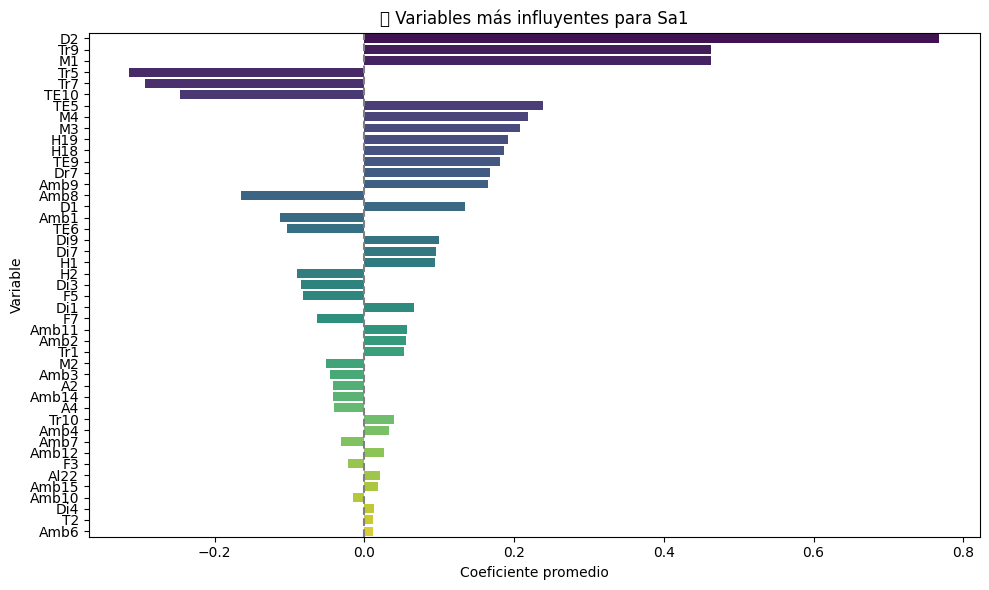



📌 Clasificación para Sa2

✅ Accuracy: 0.6504 [95% CI: 0.6427, 0.6580]
🎯 Precision: 0.5065 [95% CI: 0.4991, 0.5139]
📈 Recall: 0.7460 [95% CI: 0.7298, 0.7622]
🏆 F1-score: 0.6032 [95% CI: 0.5952, 0.6112]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
D1       0.5789
D2       0.4574
M3       0.4527
M1       0.3678
H19      0.3161
TE9      0.2638
Tr9      0.2367
F5      -0.1849
TE5      0.1802
Di1      0.1788
A2      -0.1552
M2       0.1487
Tr7     -0.1271
Amb11   -0.1136
Amb4     0.1119
Amb13   -0.0983
TE10    -0.0940
H18      0.0922
F1      -0.0921
Al22     0.0912
Amb8    -0.0892
H1       0.0867
Tr10     0.0771
Di9      0.0749
H4       0.0721
Amb14   -0.0715
F3      -0.0704
Amb3    -0.0640
Tr5     -0.0575
TE7      0.0496
H2      -0.0468
A4      -0.0459
Di7     -0.0456
Tr1     -0.0375
Di4      0.0327
Dr7      0.0326
M4       0.0319
Amb10    0.0314
Tr8     -0.0280
Amb7    -0.0277
Amb12    0.0260
TE6      0.0259
H3      -0.0256
Amb5    -0.0244
Amb1    -0.0233
T2    

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


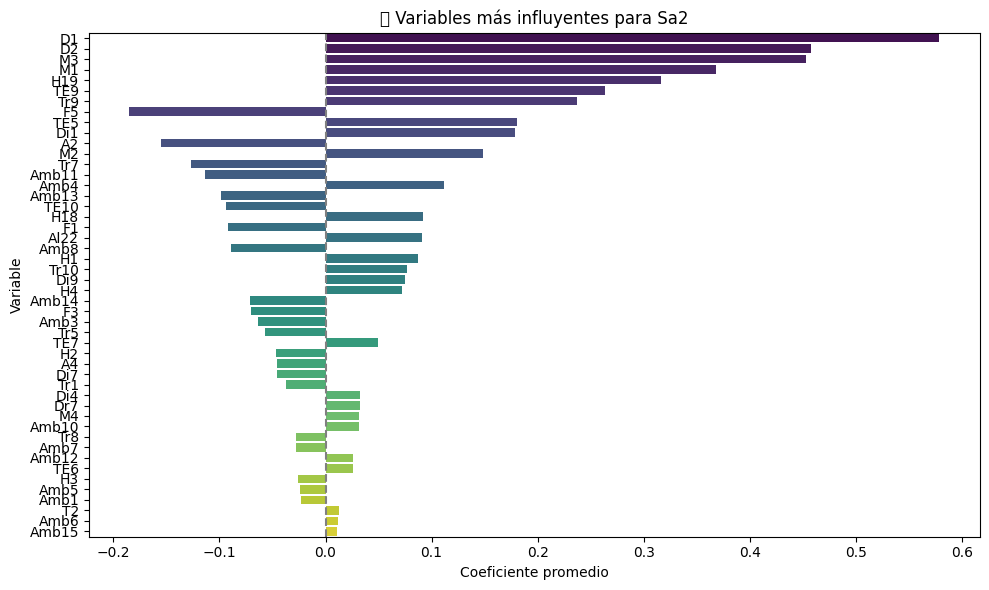



📌 Clasificación para Sa3

✅ Accuracy: 0.9008 [95% CI: 0.8988, 0.9029]
🎯 Precision: 0.0158 [95% CI: -0.0199, 0.0515]
📈 Recall: 0.0022 [95% CI: -0.0027, 0.0070]
🏆 F1-score: 0.0038 [95% CI: -0.0048, 0.0124]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
M3       0.0576
H19      0.0462
TE10    -0.0434
Amb11    0.0345
Tr5      0.0307
Dr7      0.0288
M1       0.0274
TE9      0.0253
M4       0.0252
Tr9     -0.0224
Amb10    0.0223
Tr7      0.0202
TE5      0.0177
Amb13    0.0176
F5      -0.0163
Amb3    -0.0161
Amb5    -0.0130
dtype: float64


<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


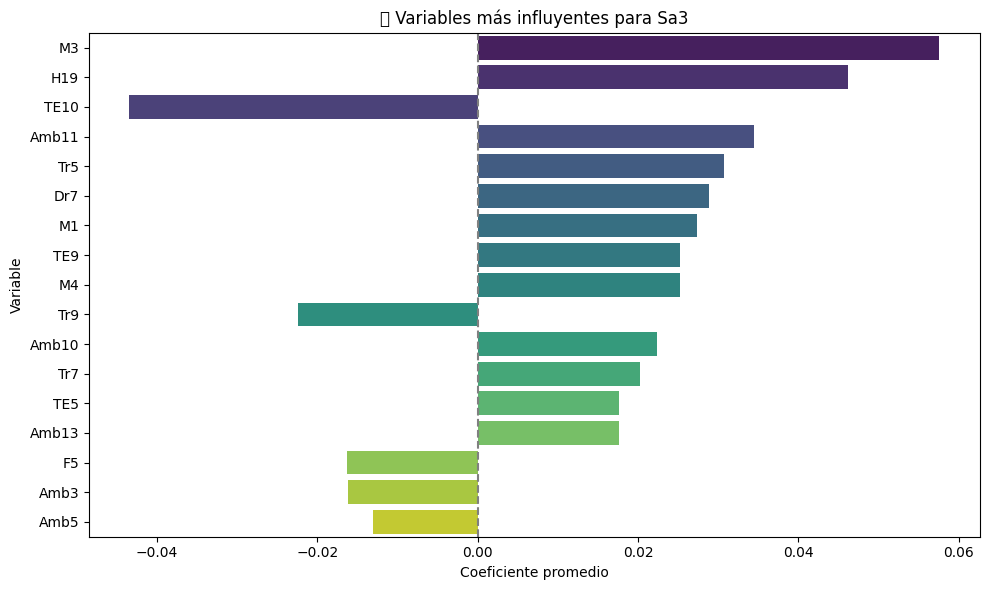



📌 Clasificación para Sa4

✅ Accuracy: 0.5697 [95% CI: 0.5597, 0.5798]
🎯 Precision: 0.5387 [95% CI: 0.5325, 0.5450]
📈 Recall: 0.9124 [95% CI: 0.9027, 0.9221]
🏆 F1-score: 0.6774 [95% CI: 0.6714, 0.6834]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
M1       0.7095
H19      0.4721
M3       0.4059
M2       0.3933
D1       0.3855
M4       0.3449
TE9      0.2722
TE5      0.2398
D2       0.2321
TE10    -0.1753
H4       0.1532
Di7      0.1384
F5      -0.1275
A4      -0.1103
Di1      0.1085
Amb4    -0.1016
Dr7      0.0938
Tr7      0.0843
Tr9      0.0782
F3      -0.0760
Amb2     0.0698
Tr8      0.0697
F1       0.0638
Amb9     0.0623
Amb3    -0.0598
Al22     0.0594
A2      -0.0544
F7      -0.0493
Di9      0.0450
TE7      0.0442
Amb7    -0.0434
Tr1      0.0363
Amb8    -0.0340
Amb11   -0.0289
Amb1    -0.0288
Amb12    0.0262
Amb10   -0.0240
Amb13    0.0208
H18      0.0205
Amb5     0.0204
Tr5     -0.0184
H1       0.0182
H2      -0.0140
Di4     -0.0129
Amb15   -0.0127
Tr10  

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


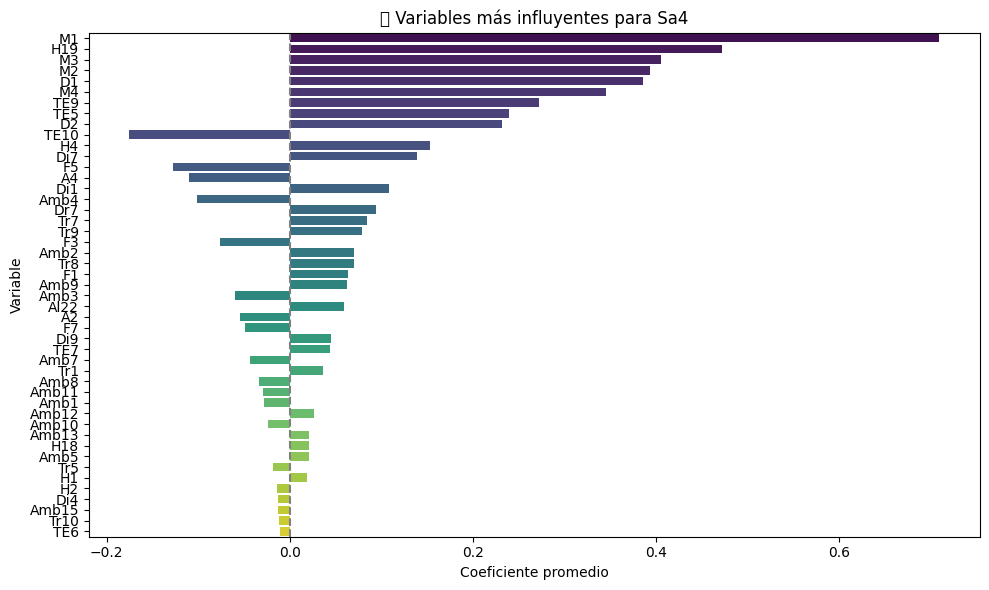



📌 Clasificación para Sa5

✅ Accuracy: 0.7440 [95% CI: 0.7358, 0.7522]
🎯 Precision: 0.5670 [95% CI: 0.5565, 0.5776]
📈 Recall: 0.7389 [95% CI: 0.7255, 0.7522]
🏆 F1-score: 0.6416 [95% CI: 0.6310, 0.6521]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
D1       1.1775
Tr9      0.7341
D2       0.5746
H19      0.5365
M3       0.4771
M1       0.4539
M4       0.4063
M2       0.3517
Amb8    -0.3049
TE5      0.2638
Tr7      0.2621
TE9      0.2300
Di1      0.1773
F5      -0.1752
Amb10   -0.1560
Di4     -0.1393
Tr5     -0.1362
Amb1    -0.1342
Amb11    0.1200
H4       0.1197
F3      -0.1172
Tr8      0.1153
A2      -0.1037
F1      -0.1001
TE10    -0.0916
Tr1     -0.0866
H18      0.0851
Dr7     -0.0688
Amb13   -0.0632
Amb9     0.0630
Di9     -0.0623
Di7      0.0616
Amb2    -0.0563
A4      -0.0526
TE7      0.0523
Amb7     0.0464
T2       0.0428
Amb15   -0.0389
Tr10     0.0367
Amb14    0.0338
Amb12   -0.0304
Amb4    -0.0300
Di3     -0.0280
TE6     -0.0153
H1      -0.0131
H3    

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


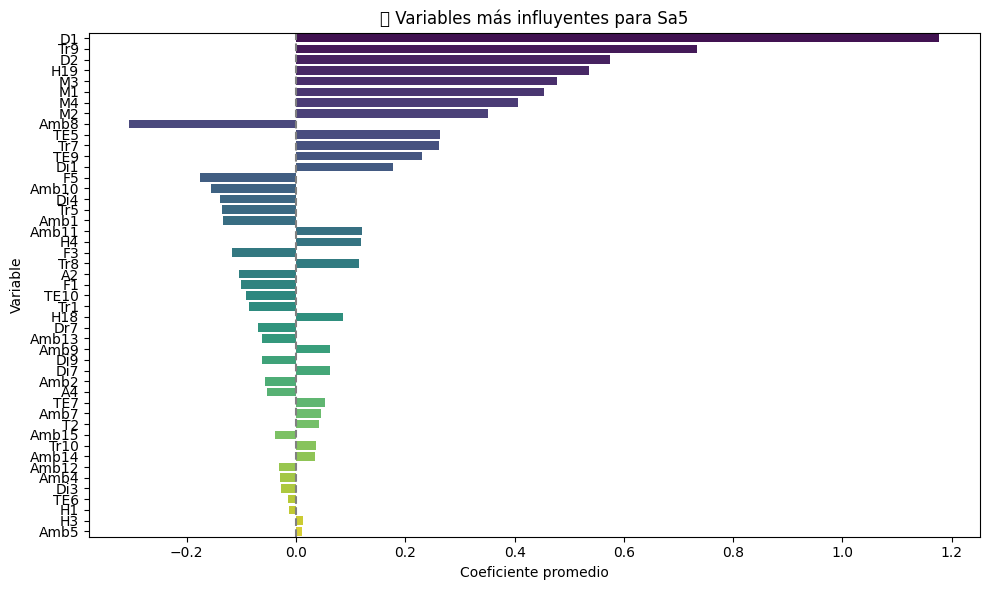



📌 Clasificación para Sa6

✅ Accuracy: 0.8487 [95% CI: 0.8439, 0.8536]
🎯 Precision: 0.6571 [95% CI: 0.6443, 0.6700]
📈 Recall: 0.5433 [95% CI: 0.5209, 0.5656]
🏆 F1-score: 0.5945 [95% CI: 0.5776, 0.6113]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
M3       2.5311
M2       1.3218
M4       0.7433
TE5      0.6212
TE9      0.5523
TE10    -0.4623
D1       0.4526
M1       0.4081
Tr7      0.3804
Tr9      0.3555
H19      0.3452
Amb2     0.3255
Amb8    -0.2338
Amb9     0.2047
A2      -0.1872
T2       0.1798
Amb13    0.1533
A4      -0.1412
Amb4    -0.1372
Amb14   -0.1367
Di7      0.1294
Amb10   -0.1179
Di3     -0.1143
Tr5      0.1075
Amb15    0.1070
Di9      0.1003
Di1      0.0892
Tr8     -0.0868
F1      -0.0764
Amb6     0.0739
Al22    -0.0724
Amb5    -0.0700
F3      -0.0697
H18      0.0671
Tr10     0.0597
TE7      0.0501
H1      -0.0429
Amb12   -0.0395
TE6     -0.0313
D2       0.0296
Tr1     -0.0246
Amb3     0.0242
H4       0.0240
Amb1     0.0221
H3      -0.0195
F5    

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


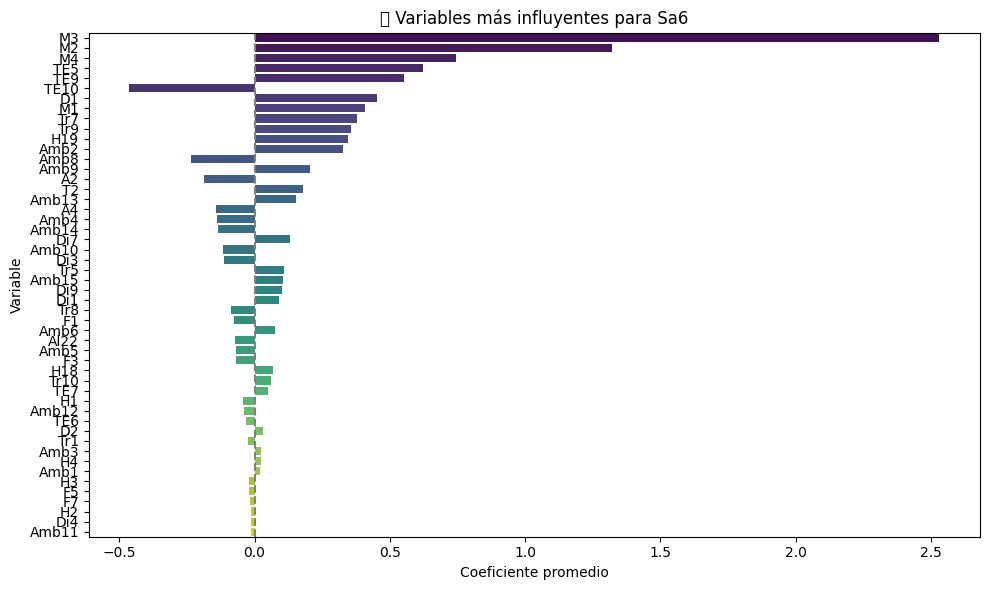



📌 Clasificación para Sa7

✅ Accuracy: 0.9442 [95% CI: 0.9408, 0.9475]
🎯 Precision: 0.0343 [95% CI: -0.0076, 0.0762]
📈 Recall: 0.0068 [95% CI: -0.0015, 0.0150]
🏆 F1-score: 0.0113 [95% CI: -0.0024, 0.0250]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
Amb2     0.4684
D2       0.2077
Di9     -0.1999
M3       0.1901
Dr7      0.1882
Tr5     -0.1598
F5      -0.1535
Tr8      0.1352
H19      0.1238
Di3      0.0994
M4       0.0907
TE9     -0.0880
Amb10    0.0877
M2       0.0872
Tr9     -0.0871
Tr1      0.0811
D1       0.0800
Amb1    -0.0736
Di4     -0.0729
Tr10    -0.0722
TE10     0.0717
TE6      0.0716
Amb12   -0.0574
H2       0.0532
H1       0.0447
F3      -0.0420
Tr7     -0.0415
Amb14   -0.0405
H3      -0.0375
Amb5    -0.0341
F7      -0.0313
Di7      0.0289
A4       0.0207
Amb8     0.0206
Amb7     0.0191
H4      -0.0178
T2       0.0174
Di1     -0.0173
Amb11    0.0164
A2       0.0163
Amb9    -0.0158
H18      0.0158
Amb3     0.0141
TE7      0.0134
Amb13    0.0132
M1 

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


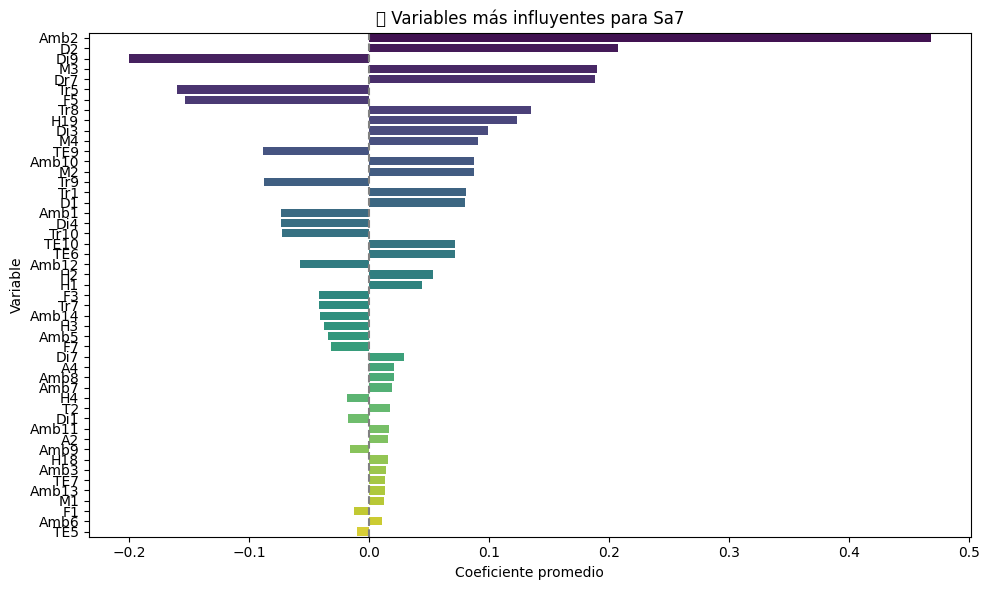



📌 Clasificación para Sa8

✅ Accuracy: 0.8553 [95% CI: 0.8527, 0.8580]
🎯 Precision: 0.2945 [95% CI: 0.2734, 0.3157]
📈 Recall: 0.1084 [95% CI: 0.0925, 0.1244]
🏆 F1-score: 0.1578 [95% CI: 0.1382, 0.1773]

🌟 Variables más influyentes en la predicción (coeficientes promedio):
H19      0.6141
Tr9      0.4956
Amb9     0.4221
M1       0.3641
Dr7      0.3497
M3       0.3369
Tr7      0.2764
M2       0.2631
TE5      0.2492
M4       0.2402
F5      -0.2049
TE10    -0.1616
Tr8     -0.1550
Di3      0.1514
T2       0.1461
F7       0.1397
H4       0.1375
Al22    -0.1317
F3      -0.1278
Amb8    -0.1218
Amb10    0.1169
Tr5     -0.1112
Amb14   -0.1064
A2      -0.0985
TE7      0.0952
TE6      0.0884
Di9     -0.0860
Amb1     0.0813
D2       0.0801
Tr1      0.0708
Amb11   -0.0695
D1      -0.0685
Amb3    -0.0679
H18      0.0669
Amb7    -0.0636
Amb4     0.0616
Di1      0.0550
Amb12    0.0549
H2       0.0474
Amb13   -0.0470
H3      -0.0449
Amb5    -0.0210
Amb15   -0.0199
Tr10    -0.0186
A4       0.0173
H1    

<ipython-input-3-240452551>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
<ipython-input-3-240452551>:103: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-240452551>:104: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f"importantes_{objetivo}.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


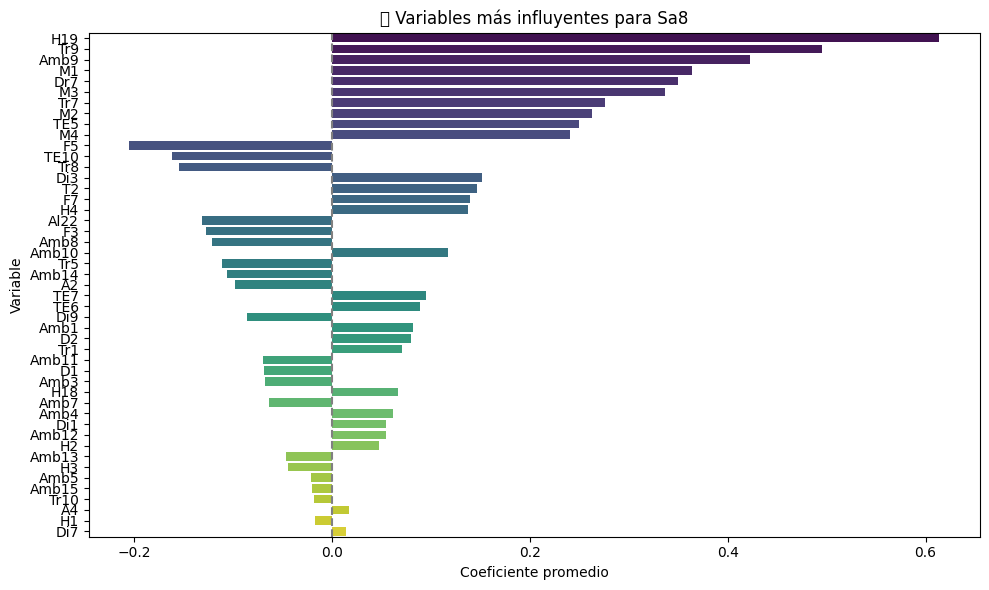

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import sem, t

# 1. Cargar datos
df = pd.read_csv('/content/sample_data/bhs_final.csv', index_col='C1')

# 2. Variables predictoras
predictoras = [
    'D1', 'D2', 'M1', 'M2', 'M3', 'M4', 'A2', 'A4', 'Di1', 'Di3', 'Di4', 'Di7', 'Di9',
    'F1', 'F3', 'F5', 'F7', 'T2', 'Al22', 'Dr7',
    'H1', 'H2', 'H3', 'H4', 'H18', 'H19',
    'TE10', 'TE5', 'TE6', 'TE7', 'TE9',
    'Tr1', 'Tr10', 'Tr5', 'Tr7', 'Tr8', 'Tr9',
    'Amb1', 'Amb2', 'Amb3', 'Amb4', 'Amb5', 'Amb6', 'Amb7', 'Amb8', 'Amb9', 'Amb10',
    'Amb11', 'Amb12', 'Amb13', 'Amb14', 'Amb15'
]

# 3. Variables objetivo
objetivos = [f'Sa{i}' for i in range(1, 9)]

# 4. Umbral personalizado
umbral = 0.3

# 5. Loop por cada variable objetivo
for objetivo in objetivos:
    print(f"\n\n=========================\n📌 Clasificación para {objetivo}\n=========================")

    df_filtrado = df.dropna(subset=[objetivo])
    clases = df_filtrado[objetivo].unique()
    if len(clases) < 2:
        print(f"⚠️  Solo hay una clase presente en {objetivo}. Se omite.")
        continue

    # Inicializar almacenamiento de métricas y coeficientes
    accs, precs, recs, f1s = [], [], [], []
    coef_matrix = []

    for i in range(10):
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(df_filtrado[predictoras])
        y = df_filtrado[objetivo].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=i)

        model = LogisticRegressionCV(
            Cs=10, cv=5, penalty='elasticnet', solver='saga',
            l1_ratios=[0.5], max_iter=10000, scoring='f1', random_state=i,
            n_jobs=-1, refit=True
        )
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > umbral).astype(int)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        coef_matrix.append(model.coef_.ravel())

    # Calcular estadísticas
    def intervalo_confianza(datos):
        mean = np.mean(datos)
        interval = t.interval(0.95, len(datos)-1, loc=mean, scale=sem(datos))
        return mean, interval

    m_acc, ci_acc = intervalo_confianza(accs)
    m_prec, ci_prec = intervalo_confianza(precs)
    m_rec, ci_rec = intervalo_confianza(recs)
    m_f1, ci_f1 = intervalo_confianza(f1s)

    print(f"\n✅ Accuracy: {m_acc:.4f} [95% CI: {ci_acc[0]:.4f}, {ci_acc[1]:.4f}]")
    print(f"🎯 Precision: {m_prec:.4f} [95% CI: {ci_prec[0]:.4f}, {ci_prec[1]:.4f}]")
    print(f"📈 Recall: {m_rec:.4f} [95% CI: {ci_rec[0]:.4f}, {ci_rec[1]:.4f}]")
    print(f"🏆 F1-score: {m_f1:.4f} [95% CI: {ci_f1[0]:.4f}, {ci_f1[1]:.4f}]")

    # Variables más influyentes
    coef_mean = np.mean(coef_matrix, axis=0)
    coef_serie = pd.Series(coef_mean, index=predictoras)
    importantes = coef_serie[coef_serie.abs() > 0.01].sort_values(key=abs, ascending=False)

    if importantes.empty:
        print("⚠️  Ninguna variable tiene peso significativo (> 0.01).")
    else:
        print("\n🌟 Variables más influyentes en la predicción (coeficientes promedio):")
        print(importantes.round(4))

        # 📊 Gráfico de barras
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importantes.values, y=importantes.index, palette="viridis")
        plt.title(f'🌟 Variables más influyentes para {objetivo}')
        plt.xlabel('Coeficiente promedio')
        plt.ylabel('Variable')
        plt.axvline(0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.savefig(f"importantes_{objetivo}.png")
        plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

# 1. Cargar datos
df = pd.read_csv('/content/sample_data/bhs_final.csv', index_col='C1')

# 2. Variables predictoras
predictoras = [
    'D1', 'D2', 'M1', 'M2', 'M3', 'M4', 'A2', 'A4', 'Di1', 'Di3', 'Di4', 'Di7', 'Di9',
    'F1', 'F3', 'F5', 'F7', 'T2', 'Al22', 'Dr7', 'H1', 'H2', 'H3', 'H4', 'H18', 'H19',
    'TE10', 'TE5', 'TE6', 'TE7', 'TE9', 'Tr1', 'Tr10', 'Tr5', 'Tr7', 'Tr8', 'Tr9',
    'Amb1', 'Amb2', 'Amb3', 'Amb4', 'Amb5', 'Amb6', 'Amb7', 'Amb8', 'Amb9', 'Amb10',
    'Amb11', 'Amb12', 'Amb13', 'Amb14', 'Amb15'
]

# 3. Variables objetivo
objetivos = [f'Sa{i}' for i in range(1, 9)]

# 4. Parámetros
umbral = 0.3
N = 10

# 5. Loop para cada variable objetivo
for objetivo in objetivos:
    print(f"\n📌 Clasificación para {objetivo}")
    df_filtrado = df.dropna(subset=[objetivo])

    clases = df_filtrado[objetivo].unique()
    if len(clases) < 2:
        print(f"⚠️  Solo hay una clase presente en {objetivo}. Se omite.")
        continue

    accs, precs, recs, f1s = [], [], [], []
    importancias = []

    for seed in range(N):
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(df_filtrado[predictoras])
        y = df_filtrado[objetivo].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )

        model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=seed
        )
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > umbral).astype(int)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        importancias.append(model.feature_importances_)

    # 📊 Función para resumen estadístico
    def resumen(m):
        arr = np.array(m)
        media = np.mean(arr)
        std = np.std(arr, ddof=1)
        ci = stats.t.interval(0.95, len(arr)-1, loc=media, scale=std/np.sqrt(len(arr)))
        return media, std, ci

    acc_mu, acc_std, acc_ci = resumen(accs)
    prec_mu, prec_std, prec_ci = resumen(precs)
    rec_mu, rec_std, rec_ci = resumen(recs)
    f1_mu, f1_std, f1_ci = resumen(f1s)

    print(f"✅ Accuracy: {acc_mu:.4f} ± {acc_std:.4f} [95% CI: {acc_ci[0]:.4f}, {acc_ci[1]:.4f}]")
    print(f"🎯 Precision: {prec_mu:.4f} ± {prec_std:.4f} [95% CI: {prec_ci[0]:.4f}, {prec_ci[1]:.4f}]")
    print(f"📈 Recall: {rec_mu:.4f} ± {rec_std:.4f} [95% CI: {rec_ci[0]:.4f}, {rec_ci[1]:.4f}]")
    print(f"🏆 F1-score: {f1_mu:.4f} ± {f1_std:.4f} [95% CI: {f1_ci[0]:.4f}, {f1_ci[1]:.4f}]")

    # 🔍 Importancia media de características
    importancias_mean = np.mean(importancias, axis=0)
    importantes = pd.Series(importancias_mean, index=predictoras)
    importantes = importantes[importantes > 0.01].sort_values(ascending=False)

    if importantes.empty:
        print("⚠️  Ninguna variable tiene importancia significativa (> 0.01).")
    else:
        print("\n🌟 Variables más influyentes (importancia promedio):")
        print(importantes)

        # 📊 Gráfico
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')
        plt.title(f'Importancia promedio de variables para {objetivo}')
        plt.xlabel('Importancia media')
        plt.tight_layout()
        plt.savefig(f'importantes_{objetivo}.png')
        plt.close()



📌 Clasificación para Sa1
✅ Accuracy: 0.7237 ± 0.0098 [95% CI: 0.7167, 0.7308]
🎯 Precision: 0.5709 ± 0.0120 [95% CI: 0.5623, 0.5795]
📈 Recall: 0.7760 ± 0.0153 [95% CI: 0.7650, 0.7869]
🏆 F1-score: 0.6577 ± 0.0101 [95% CI: 0.6505, 0.6650]

🌟 Variables más influyentes (importancia promedio):
D2      0.698160
TE9     0.042937
M1      0.036282
TE6     0.020194
TE10    0.015956
M4      0.013615
A4      0.010405
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa2
✅ Accuracy: 0.6553 ± 0.0112 [95% CI: 0.6473, 0.6633]
🎯 Precision: 0.5111 ± 0.0107 [95% CI: 0.5035, 0.5188]
📈 Recall: 0.7506 ± 0.0234 [95% CI: 0.7338, 0.7674]
🏆 F1-score: 0.6080 ± 0.0128 [95% CI: 0.5989, 0.6172]

🌟 Variables más influyentes (importancia promedio):
D2      0.522017
D1      0.075166
M1      0.045976
A2      0.036246
M3      0.027174
A4      0.019441
F5      0.018740
TE6     0.017649
TE9     0.017354
TE7     0.016255
F3      0.014439
Amb4    0.010393
H3      0.010391
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa3
✅ Accuracy: 0.8919 ± 0.0036 [95% CI: 0.8894, 0.8945]
🎯 Precision: 0.2093 ± 0.0631 [95% CI: 0.1641, 0.2544]
📈 Recall: 0.0360 ± 0.0127 [95% CI: 0.0269, 0.0450]
🏆 F1-score: 0.0608 ± 0.0201 [95% CI: 0.0464, 0.0752]

🌟 Variables más influyentes (importancia promedio):
TE6      0.064418
M3       0.057574
A2       0.042627
T2       0.041872
TE10     0.040452
Amb14    0.040141
M1       0.035074
F1       0.033784
D2       0.033783
TE9      0.030205
TE7      0.027451
Di1      0.026477
M4       0.026449
Al22     0.026104
Di7      0.025204
A4       0.023586
Dr7      0.023535
Amb7     0.022529
F3       0.021248
H3       0.020969
H1       0.019064
Amb15    0.017729
H19      0.017595
Amb12    0.016538
Tr10     0.016096
Amb11    0.015085
Amb8     0.014730
Amb4     0.014516
F5       0.013727
Amb5     0.013708
Di3      0.012561
Amb9     0.010831
Amb13    0.010522
Tr5      0.010214
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa4
✅ Accuracy: 0.5651 ± 0.0091 [95% CI: 0.5586, 0.5716]
🎯 Precision: 0.5351 ± 0.0052 [95% CI: 0.5314, 0.5388]
📈 Recall: 0.9260 ± 0.0157 [95% CI: 0.9147, 0.9373]
🏆 F1-score: 0.6782 ± 0.0080 [95% CI: 0.6725, 0.6840]

🌟 Variables más influyentes (importancia promedio):
M1       0.222390
D2       0.184734
D1       0.057707
M2       0.043500
M4       0.039527
M3       0.031623
F5       0.030903
H19      0.024806
TE10     0.023732
TE9      0.023573
A2       0.023149
TE6      0.018807
TE7      0.018638
F1       0.013834
A4       0.013698
Amb15    0.012359
TE5      0.012358
Amb6     0.011785
T2       0.011667
H3       0.011200
Al22     0.011035
Di7      0.010896
H2       0.010653
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa5
✅ Accuracy: 0.7855 ± 0.0141 [95% CI: 0.7754, 0.7956]
🎯 Precision: 0.6303 ± 0.0220 [95% CI: 0.6145, 0.6461]
📈 Recall: 0.7476 ± 0.0219 [95% CI: 0.7319, 0.7633]
🏆 F1-score: 0.6837 ± 0.0182 [95% CI: 0.6707, 0.6968]

🌟 Variables más influyentes (importancia promedio):
D2       0.349064
D1       0.197589
Amb10    0.151583
Dr7      0.051890
M4       0.028045
A2       0.026363
M1       0.023348
M3       0.014297
M2       0.013159
F3       0.010509
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa6
✅ Accuracy: 0.8480 ± 0.0044 [95% CI: 0.8449, 0.8511]
🎯 Precision: 0.6502 ± 0.0171 [95% CI: 0.6380, 0.6624]
📈 Recall: 0.5564 ± 0.0187 [95% CI: 0.5431, 0.5697]
🏆 F1-score: 0.5994 ± 0.0112 [95% CI: 0.5914, 0.6074]

🌟 Variables más influyentes (importancia promedio):
M3      0.573064
M2      0.123295
A2      0.037561
M4      0.036002
TE10    0.021945
M1      0.018127
T2      0.013571
A4      0.013149
TE9     0.011299
D1      0.010924
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa7
✅ Accuracy: 0.9421 ± 0.0025 [95% CI: 0.9403, 0.9439]
🎯 Precision: 0.1148 ± 0.0971 [95% CI: 0.0453, 0.1843]
📈 Recall: 0.0162 ± 0.0140 [95% CI: 0.0062, 0.0262]
🏆 F1-score: 0.0282 ± 0.0241 [95% CI: 0.0110, 0.0454]

🌟 Variables más influyentes (importancia promedio):
D2       0.324942
M3       0.040856
M4       0.040436
TE7      0.033441
TE6      0.030872
Di1      0.025886
Dr7      0.023267
A2       0.022092
M2       0.019046
Amb14    0.019031
T2       0.018992
TE9      0.018934
Di4      0.018204
D1       0.018104
Amb13    0.017761
Al22     0.017564
Amb7     0.017132
Amb4     0.016723
A4       0.016344
H3       0.016275
Amb12    0.016231
F3       0.015982
Amb3     0.015595
Amb15    0.015457
Di9      0.013717
F5       0.012951
Amb5     0.012185
Tr9      0.011724
H2       0.011348
Amb1     0.011091
Tr8      0.010622
H1       0.010368
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa8
✅ Accuracy: 0.8567 ± 0.0032 [95% CI: 0.8545, 0.8590]
🎯 Precision: 0.3162 ± 0.0264 [95% CI: 0.2973, 0.3350]
📈 Recall: 0.1197 ± 0.0200 [95% CI: 0.1054, 0.1340]
🏆 F1-score: 0.1730 ± 0.0233 [95% CI: 0.1564, 0.1897]

🌟 Variables más influyentes (importancia promedio):
M2       0.073542
Amb11    0.055991
M1       0.054460
M3       0.051491
D2       0.050585
TE6      0.047374
TE7      0.035958
Amb12    0.034623
Amb14    0.031599
M4       0.031334
H19      0.028009
Amb10    0.027964
Al22     0.027494
Tr9      0.025600
A2       0.025023
T2       0.024862
Dr7      0.023640
Amb9     0.023601
F5       0.021149
F3       0.020450
Amb15    0.019662
Amb4     0.018272
Amb8     0.016618
A4       0.016123
Amb5     0.015585
Di1      0.015133
TE10     0.014183
F7       0.014021
Amb6     0.010990
H2       0.010497
Amb3     0.010461
D1       0.010440
dtype: float64


<ipython-input-4-3752407193>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

# 1. Cargar datos
df = pd.read_csv('/content/sample_data/bhs_final.csv', index_col='C1')

# 2. Variables predictoras
predictoras = [
    'D1', 'D2',
    'M1', 'M2', 'M3', 'M4', 'A2', 'A4', 'Di1', 'Di3', 'Di4', 'Di7', 'Di9',
    'F1', 'F3', 'F5', 'F7', 'T2', 'Al22', 'Dr7',
    'H1', 'H2', 'H3', 'H4', 'H18', 'H19',
    'TE10', 'TE5', 'TE6', 'TE7', 'TE9',
    'Tr1', 'Tr10', 'Tr5', 'Tr7', 'Tr8', 'Tr9',
    'Amb1', 'Amb2', 'Amb3', 'Amb4', 'Amb5', 'Amb6', 'Amb7', 'Amb8', 'Amb9', 'Amb10',
    'Amb11', 'Amb12', 'Amb13', 'Amb14', 'Amb15'
]

# 3. Variables objetivo
objetivos = [f'Sa{i}' for i in range(1, 9)]

# 4. Umbral personalizado
umbral = 0.3

# 5. Número de repeticiones
N = 10

def resumen(m):
    arr = np.array(m)
    media = np.mean(arr)
    std = np.std(arr, ddof=1)
    ci = stats.t.interval(0.95, len(arr)-1, loc=media, scale=std/np.sqrt(len(arr)))
    return media, std, ci

for objetivo in objetivos:
    print(f"\n📌 Clasificación para {objetivo}")
    df_filtrado = df.dropna(subset=[objetivo])

    clases = df_filtrado[objetivo].unique()
    if len(clases) < 2:
        print(f"⚠️  Solo hay una clase presente en {objetivo}. Se omite.")
        continue

    accs, precs, recs, f1s = [], [], [], []
    importancias = []

    for seed in range(N):
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(df_filtrado[predictoras])
        y = df_filtrado[objetivo].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )

        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            random_state=seed,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > umbral).astype(int)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        importancias.append(model.feature_importances_)

    acc_mu, acc_std, acc_ci = resumen(accs)
    prec_mu, prec_std, prec_ci = resumen(precs)
    rec_mu, rec_std, rec_ci = resumen(recs)
    f1_mu, f1_std, f1_ci = resumen(f1s)

    print(f"✅ Accuracy: {acc_mu:.4f} ± {acc_std:.4f} [95% CI: {acc_ci[0]:.4f}, {acc_ci[1]:.4f}]")
    print(f"🎯 Precision: {prec_mu:.4f} ± {prec_std:.4f} [95% CI: {prec_ci[0]:.4f}, {prec_ci[1]:.4f}]")
    print(f"📈 Recall: {rec_mu:.4f} ± {rec_std:.4f} [95% CI: {rec_ci[0]:.4f}, {rec_ci[1]:.4f}]")
    print(f"🏆 F1-score: {f1_mu:.4f} ± {f1_std:.4f} [95% CI: {f1_ci[0]:.4f}, {f1_ci[1]:.4f}]")

    # Importancia media
    importancias_mean = np.mean(importancias, axis=0)
    importantes = pd.Series(importancias_mean, index=predictoras)
    importantes = importantes[importantes > 0.01].sort_values(ascending=False)

    if importantes.empty:
        print("⚠️  Ninguna variable tiene importancia significativa (> 0.01).")
    else:
        print("\n🌟 Variables más influyentes (importancia promedio):")
        print(importantes)

        # Gráfico
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')
        plt.title(f'Importancia promedio de variables para {objetivo}')
        plt.xlabel('Importancia media')
        plt.tight_layout()
        plt.savefig(f'importantes_{objetivo}.png')
        plt.close()



📌 Clasificación para Sa1
✅ Accuracy: 0.7141 ± 0.0090 [95% CI: 0.7077, 0.7205]
🎯 Precision: 0.5588 ± 0.0099 [95% CI: 0.5517, 0.5659]
📈 Recall: 0.7810 ± 0.0199 [95% CI: 0.7667, 0.7952]
🏆 F1-score: 0.6514 ± 0.0107 [95% CI: 0.6437, 0.6590]

🌟 Variables más influyentes (importancia promedio):
D2       0.138914
TE7      0.046502
TE6      0.036883
H1       0.032712
TE9      0.030706
H3       0.029182
Amb15    0.028743
Al22     0.028601
T2       0.027084
A2       0.026864
H2       0.024290
A4       0.024084
Amb6     0.024053
F1       0.023220
Amb14    0.022275
M1       0.021344
F7       0.020455
Amb12    0.019915
Amb3     0.019899
Amb7     0.019112
F3       0.018632
Amb5     0.018192
Di4      0.017688
H18      0.017136
F5       0.016998
TE10     0.016037
D1       0.015386
Amb4     0.014693
Tr10     0.014428
M4       0.014426
Amb1     0.013890
Di1      0.013163
Amb8     0.012722
Tr8      0.011449
Amb9     0.011287
Amb10    0.011150
Tr1      0.011008
dtype: float64


<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa2
✅ Accuracy: 0.6282 ± 0.0081 [95% CI: 0.6224, 0.6341]
🎯 Precision: 0.4861 ± 0.0071 [95% CI: 0.4810, 0.4912]
📈 Recall: 0.7574 ± 0.0226 [95% CI: 0.7412, 0.7735]
🏆 F1-score: 0.5920 ± 0.0096 [95% CI: 0.5852, 0.5989]

🌟 Variables más influyentes (importancia promedio):
D2       0.091871
TE7      0.036238
TE6      0.035171
Amb15    0.032340
H3       0.031643
Al22     0.031554
A2       0.031438
H1       0.029954
T2       0.029190
Amb6     0.026457
A4       0.026362
Amb14    0.025928
F1       0.024178
D1       0.023401
H2       0.023211
Amb12    0.022598
F3       0.021949
Amb3     0.021762
Amb7     0.021556
F7       0.021144
TE9      0.021126
M1       0.020380
Amb5     0.019823
Di4      0.019554
H18      0.019249
F5       0.018033
Amb4     0.016539
Tr10     0.016406
TE10     0.016287
Di1      0.014937
Amb1     0.014711
Tr1      0.012857
Amb8     0.012536
Amb9     0.012267
Tr8      0.012212
M3       0.012063
Amb10    0.011914
Amb13    0.011853
M4       0.011840
H4      

<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa3
✅ Accuracy: 0.8942 ± 0.0032 [95% CI: 0.8919, 0.8965]
🎯 Precision: 0.2217 ± 0.1002 [95% CI: 0.1501, 0.2934]
📈 Recall: 0.0331 ± 0.0195 [95% CI: 0.0191, 0.0471]
🏆 F1-score: 0.0570 ± 0.0325 [95% CI: 0.0338, 0.0803]

🌟 Variables más influyentes (importancia promedio):
TE6      0.042003
D2       0.041331
Amb15    0.035877
Al22     0.034273
H3       0.033646
A2       0.032829
T2       0.031345
Amb14    0.029677
H1       0.029525
A4       0.028816
TE7      0.028808
F1       0.028028
Amb6     0.027349
H2       0.026556
Amb7     0.025104
Amb12    0.025006
Amb3     0.024515
F3       0.023354
F7       0.021905
H18      0.020938
Di4      0.020734
TE10     0.019603
TE9      0.018952
Amb5     0.018859
D1       0.017772
Tr10     0.017445
Di1      0.017388
Amb4     0.017070
Amb1     0.016547
M1       0.016321
Amb8     0.014580
Tr1      0.014580
Tr8      0.013431
Amb9     0.013323
Amb10    0.012751
Amb13    0.012318
F5       0.012302
M3       0.012051
Di3      0.011719
H4      

<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa4
✅ Accuracy: 0.5465 ± 0.0097 [95% CI: 0.5396, 0.5535]
🎯 Precision: 0.5236 ± 0.0056 [95% CI: 0.5196, 0.5276]
📈 Recall: 0.9323 ± 0.0113 [95% CI: 0.9242, 0.9403]
🏆 F1-score: 0.6706 ± 0.0068 [95% CI: 0.6657, 0.6754]

🌟 Variables más influyentes (importancia promedio):
D2       0.052508
M1       0.037871
TE6      0.036377
H3       0.034501
Amb15    0.033396
Al22     0.033199
A2       0.030597
T2       0.030059
TE7      0.028714
H1       0.028249
Amb6     0.027929
F1       0.026338
Amb14    0.026174
H2       0.025335
A4       0.024836
Amb12    0.023694
F7       0.023234
Amb3     0.022751
Amb7     0.022116
D1       0.021713
F3       0.021441
TE9      0.021194
Amb5     0.020464
Di4      0.019948
H18      0.019565
TE10     0.018026
F5       0.017635
Tr10     0.016954
Amb4     0.016259
Amb1     0.015371
Di1      0.015264
M2       0.014266
M4       0.014031
Amb8     0.013361
Tr8      0.013319
Tr1      0.013094
Amb9     0.012587
Amb10    0.012449
M3       0.011420
Amb13   

<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa5
✅ Accuracy: 0.7760 ± 0.0121 [95% CI: 0.7673, 0.7846]
🎯 Precision: 0.6109 ± 0.0177 [95% CI: 0.5983, 0.6236]
📈 Recall: 0.7662 ± 0.0208 [95% CI: 0.7513, 0.7811]
🏆 F1-score: 0.6796 ± 0.0152 [95% CI: 0.6687, 0.6905]

🌟 Variables más influyentes (importancia promedio):
D2       0.097178
D1       0.094215
TE7      0.040170
TE6      0.030903
A2       0.029016
Al22     0.026915
H3       0.026401
Amb15    0.026271
T2       0.024436
H1       0.023190
M4       0.022737
Amb6     0.022532
A4       0.021455
F1       0.020455
M1       0.020356
TE9      0.020219
Amb14    0.019996
Dr7      0.019189
F3       0.018978
Amb5     0.018952
Amb12    0.018552
H2       0.017592
M2       0.017412
Amb10    0.017276
F7       0.017108
Amb8     0.016341
Amb3     0.016011
F5       0.015415
Di4      0.015396
Di1      0.015394
Amb11    0.015022
H18      0.014958
Amb9     0.014103
TE10     0.014002
Amb7     0.013898
Amb4     0.012937
Tr10     0.012876
Amb1     0.012773
M3       0.012743
Tr1     

<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa6
✅ Accuracy: 0.8379 ± 0.0084 [95% CI: 0.8319, 0.8439]
🎯 Precision: 0.6069 ± 0.0234 [95% CI: 0.5902, 0.6237]
📈 Recall: 0.5900 ± 0.0213 [95% CI: 0.5747, 0.6052]
🏆 F1-score: 0.5981 ± 0.0180 [95% CI: 0.5852, 0.6110]

🌟 Variables más influyentes (importancia promedio):
M3       0.132093
M2       0.076532
M4       0.043813
D2       0.031500
A2       0.030683
TE6      0.028839
Amb15    0.026818
H3       0.024900
T2       0.024601
A4       0.024249
Al22     0.024218
TE7      0.023304
H1       0.022420
Amb14    0.020199
F1       0.019707
TE10     0.019616
Amb6     0.019589
H2       0.019464
M1       0.019377
TE9      0.018943
F3       0.018763
Amb3     0.018495
Amb12    0.017780
Amb7     0.017448
F7       0.015878
H18      0.015404
Di4      0.015310
D1       0.014733
Amb5     0.014700
Tr10     0.012880
Di1      0.012394
Amb4     0.012098
Amb1     0.012032
Amb9     0.011121
Dr7      0.011094
Amb8     0.011060
Amb10    0.010715
Tr1      0.010371
dtype: float64


<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa7
✅ Accuracy: 0.9440 ± 0.0018 [95% CI: 0.9427, 0.9453]
🎯 Precision: 0.0533 ± 0.0864 [95% CI: -0.0084, 0.1151]
📈 Recall: 0.0041 ± 0.0065 [95% CI: -0.0006, 0.0087]
🏆 F1-score: 0.0075 ± 0.0121 [95% CI: -0.0011, 0.0162]

🌟 Variables más influyentes (importancia promedio):
D2       0.053837
TE6      0.042773
Amb15    0.037271
H3       0.034247
A2       0.033657
TE7      0.033017
Al22     0.032662
T2       0.031004
Amb14    0.029463
A4       0.027996
Amb3     0.027915
F1       0.026933
Amb6     0.026779
Amb7     0.026132
F3       0.025215
Amb12    0.025186
H18      0.023253
Di4      0.022166
Amb5     0.020913
F7       0.020591
Di1      0.020180
H1       0.019650
Amb4     0.018850
D1       0.018673
M1       0.018107
Amb1     0.017569
H2       0.016886
TE10     0.016876
M4       0.016691
Tr8      0.016560
Tr10     0.016007
Amb8     0.015681
M3       0.015067
Tr1      0.014550
M2       0.014101
TE9      0.014095
Amb9     0.013787
Amb10    0.013270
Dr7      0.012829
H4   

<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')



📌 Clasificación para Sa8
✅ Accuracy: 0.8561 ± 0.0049 [95% CI: 0.8526, 0.8596]
🎯 Precision: 0.3344 ± 0.0383 [95% CI: 0.3070, 0.3618]
📈 Recall: 0.1438 ± 0.0170 [95% CI: 0.1317, 0.1560]
🏆 F1-score: 0.2008 ± 0.0221 [95% CI: 0.1851, 0.2166]

🌟 Variables más influyentes (importancia promedio):
TE6      0.041993
D2       0.041422
Amb15    0.035954
H3       0.034169
Al22     0.033009
A2       0.032130
T2       0.031187
Amb14    0.031043
Amb6     0.030813
TE7      0.029659
H1       0.028195
Amb12    0.027993
A4       0.027920
F1       0.026769
F3       0.025491
F7       0.024324
H2       0.023639
Amb3     0.022637
Amb7     0.021716
Amb5     0.020980
H18      0.020779
Di4      0.020068
M1       0.019777
TE10     0.019503
D1       0.019271
Amb4     0.019092
Di1      0.018108
TE9      0.017856
Tr10     0.017779
M2       0.015692
Amb1     0.015177
M3       0.014595
M4       0.013930
Tr1      0.013666
Tr8      0.012785
F5       0.012526
Amb11    0.012457
Amb13    0.011287
Amb8     0.011038
H4      

<ipython-input-5-527752438>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importantes.values, y=importantes.index, palette='viridis')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

# 1. Cargar datos
df = pd.read_csv('/content/sample_data/bhs_final.csv', index_col='C1')

# 2. Variables predictoras
predictoras = [
    'D1', 'D2',
    'M1', 'M2', 'M3', 'M4', 'A2', 'A4', 'Di1', 'Di3', 'Di4', 'Di7', 'Di9',
    'F1', 'F3', 'F5', 'F7', 'T2', 'Al22', 'Dr7',
    'H1', 'H2', 'H3', 'H4', 'H18', 'H19',
    'TE10', 'TE5', 'TE6', 'TE7', 'TE9',
    'Tr1', 'Tr10', 'Tr5', 'Tr7', 'Tr8', 'Tr9',
    'Amb1', 'Amb2', 'Amb3', 'Amb4', 'Amb5', 'Amb6', 'Amb7', 'Amb8', 'Amb9', 'Amb10',
    'Amb11', 'Amb12', 'Amb13', 'Amb14', 'Amb15'
]

# 3. Variables objetivo
objetivos = [f'Sa{i}' for i in range(1, 9)]

# 4. Umbral personalizado
umbral = 0.3

# 5. Número de repeticiones
N = 10

def resumen(m):
    arr = np.array(m)
    media = np.mean(arr)
    std = np.std(arr, ddof=1)
    ci = stats.t.interval(0.95, len(arr)-1, loc=media, scale=std/np.sqrt(len(arr)))
    return media, std, ci

for objetivo in objetivos:
    print(f"\n📌 Clasificación para {objetivo}")
    df_filtrado = df.dropna(subset=[objetivo])

    clases = df_filtrado[objetivo].unique()
    if len(clases) < 2:
        print(f"⚠️  Solo hay una clase presente en {objetivo}. Se omite.")
        continue

    accs, precs, recs, f1s = [], [], [], []

    for seed in range(N):
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(df_filtrado[predictoras])
        y = df_filtrado[objetivo].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )

        model = SVC(
            kernel='rbf',
            probability=True,
            C=1.0,
            gamma='scale',
            random_state=seed
        )
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > umbral).astype(int)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))

    acc_mu, acc_std, acc_ci = resumen(accs)
    prec_mu, prec_std, prec_ci = resumen(precs)
    rec_mu, rec_std, rec_ci = resumen(recs)
    f1_mu, f1_std, f1_ci = resumen(f1s)

    print(f"✅ Accuracy: {acc_mu:.4f} ± {acc_std:.4f} [95% CI: {acc_ci[0]:.4f}, {acc_ci[1]:.4f}]")
    print(f"🎯 Precision: {prec_mu:.4f} ± {prec_std:.4f} [95% CI: {prec_ci[0]:.4f}, {prec_ci[1]:.4f}]")
    print(f"📈 Recall: {rec_mu:.4f} ± {rec_std:.4f} [95% CI: {rec_ci[0]:.4f}, {rec_ci[1]:.4f}]")
    print(f"🏆 F1-score: {f1_mu:.4f} ± {f1_std:.4f} [95% CI: {f1_ci[0]:.4f}, {f1_ci[1]:.4f}]")

    print("\n⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.")



📌 Clasificación para Sa1
✅ Accuracy: 0.7467 ± 0.0090 [95% CI: 0.7403, 0.7531]
🎯 Precision: 0.6153 ± 0.0127 [95% CI: 0.6062, 0.6244]
📈 Recall: 0.6928 ± 0.0160 [95% CI: 0.6813, 0.7042]
🏆 F1-score: 0.6517 ± 0.0117 [95% CI: 0.6433, 0.6601]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.

📌 Clasificación para Sa2
✅ Accuracy: 0.6802 ± 0.0102 [95% CI: 0.6729, 0.6875]
🎯 Precision: 0.5407 ± 0.0125 [95% CI: 0.5317, 0.5496]
📈 Recall: 0.6859 ± 0.0262 [95% CI: 0.6671, 0.7046]
🏆 F1-score: 0.6044 ± 0.0119 [95% CI: 0.5958, 0.6129]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.

📌 Clasificación para Sa3


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


✅ Accuracy: 0.9018 ± 0.0000 [95% CI: nan, nan]
🎯 Precision: 0.0000 ± 0.0000 [95% CI: nan, nan]
📈 Recall: 0.0000 ± 0.0000 [95% CI: nan, nan]
🏆 F1-score: 0.0000 ± 0.0000 [95% CI: nan, nan]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.

📌 Clasificación para Sa4
✅ Accuracy: 0.5675 ± 0.0091 [95% CI: 0.5609, 0.5740]
🎯 Precision: 0.5372 ± 0.0053 [95% CI: 0.5334, 0.5411]
📈 Recall: 0.9106 ± 0.0191 [95% CI: 0.8969, 0.9242]
🏆 F1-score: 0.6757 ± 0.0086 [95% CI: 0.6695, 0.6819]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.

📌 Clasificación para Sa5
✅ Accuracy: 0.7944 ± 0.0113 [95% CI: 0.7864, 0.8025]
🎯 Precision: 0.6555 ± 0.0174 [95% CI: 0.6431, 0.6680]
📈 Recall: 0.7104 ± 0.0224 [95% CI: 0.6944, 0.7265]
🏆 F1-score: 0.6818 ± 0.0177 [95% CI: 0.6691, 0.6944]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.

📌 Clasificación para Sa6
✅ Accuracy: 0.8629 ± 0.0042 [95% C

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


✅ Accuracy: 0.9468 ± 0.0007 [95% CI: 0.9462, 0.9473]
🎯 Precision: 0.0000 ± 0.0000 [95% CI: nan, nan]
📈 Recall: 0.0000 ± 0.0000 [95% CI: nan, nan]
🏆 F1-score: 0.0000 ± 0.0000 [95% CI: nan, nan]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.

📌 Clasificación para Sa8
✅ Accuracy: 0.8734 ± 0.0018 [95% CI: 0.8721, 0.8746]
🎯 Precision: 0.4492 ± 0.1278 [95% CI: 0.3577, 0.5406]
📈 Recall: 0.0298 ± 0.0124 [95% CI: 0.0209, 0.0387]
🏆 F1-score: 0.0556 ± 0.0221 [95% CI: 0.0397, 0.0714]

⚠️  SVM con kernel no lineal (RBF) no proporciona coeficientes interpretables directamente.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

# 1. Cargar datos
df = pd.read_csv('/content/sample_data/bhs_final.csv', index_col='C1')

# 2. Variables predictoras
predictoras = [
    'D1', 'D2',
    'M1', 'M2', 'M3', 'M4', 'A2', 'A4', 'Di1', 'Di3', 'Di4', 'Di7', 'Di9',
    'F1', 'F3', 'F5', 'F7', 'T2', 'Al22', 'Dr7',
    'H1', 'H2', 'H3', 'H4', 'H18', 'H19',
    'TE10', 'TE5', 'TE6', 'TE7', 'TE9',
    'Tr1', 'Tr10', 'Tr5', 'Tr7', 'Tr8', 'Tr9',
    'Amb1', 'Amb2', 'Amb3', 'Amb4', 'Amb5', 'Amb6', 'Amb7', 'Amb8', 'Amb9', 'Amb10',
    'Amb11', 'Amb12', 'Amb13', 'Amb14', 'Amb15'
]

# 3. Variables objetivo
objetivos = [f'Sa{i}' for i in range(1, 9)]

# 4. Umbral personalizado para clasificar como clase 1
umbral = 0.3

# 5. Número de repeticiones
N = 10

def resumen(m):
    arr = np.array(m)
    media = np.mean(arr)
    std = np.std(arr, ddof=1)
    ci = stats.t.interval(0.95, len(arr)-1, loc=media, scale=std/np.sqrt(len(arr)))
    return media, std, ci

for objetivo in objetivos:
    print(f"\n📌 Clasificación para {objetivo}")
    df_filtrado = df.dropna(subset=[objetivo])

    clases = df_filtrado[objetivo].unique()
    if len(clases) < 2:
        print(f"⚠️  Solo hay una clase presente en {objetivo}. Se omite.")
        continue

    accs, precs, recs, f1s = [], [], [], []

    for seed in range(N):
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(df_filtrado[predictoras])
        y = df_filtrado[objetivo].astype(int).values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )

        model = GaussianNB()
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > umbral).astype(int)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))

    acc_mu, acc_std, acc_ci = resumen(accs)
    prec_mu, prec_std, prec_ci = resumen(precs)
    rec_mu, rec_std, rec_ci = resumen(recs)
    f1_mu, f1_std, f1_ci = resumen(f1s)

    print(f"✅ Accuracy: {acc_mu:.4f} ± {acc_std:.4f} [95% CI: {acc_ci[0]:.4f}, {acc_ci[1]:.4f}]")
    print(f"🎯 Precision: {prec_mu:.4f} ± {prec_std:.4f} [95% CI: {prec_ci[0]:.4f}, {prec_ci[1]:.4f}]")
    print(f"📈 Recall: {rec_mu:.4f} ± {rec_std:.4f} [95% CI: {rec_ci[0]:.4f}, {rec_ci[1]:.4f}]")
    print(f"🏆 F1-score: {f1_mu:.4f} ± {f1_std:.4f} [95% CI: {f1_ci[0]:.4f}, {f1_ci[1]:.4f}]")

    print("\n⚠️  Naive Bayes no proporciona una medida directa de importancia de variables.")



📌 Clasificación para Sa1
✅ Accuracy: 0.7164 ± 0.0095 [95% CI: 0.7097, 0.7232]
🎯 Precision: 0.5729 ± 0.0116 [95% CI: 0.5646, 0.5811]
📈 Recall: 0.6725 ± 0.0251 [95% CI: 0.6545, 0.6904]
🏆 F1-score: 0.6185 ± 0.0153 [95% CI: 0.6076, 0.6295]

⚠️  Naive Bayes no proporciona una medida directa de importancia de variables.

📌 Clasificación para Sa2
✅ Accuracy: 0.6735 ± 0.0096 [95% CI: 0.6666, 0.6803]
🎯 Precision: 0.5373 ± 0.0118 [95% CI: 0.5288, 0.5457]
📈 Recall: 0.6006 ± 0.0235 [95% CI: 0.5838, 0.6174]
🏆 F1-score: 0.5671 ± 0.0160 [95% CI: 0.5556, 0.5785]

⚠️  Naive Bayes no proporciona una medida directa de importancia de variables.

📌 Clasificación para Sa3
✅ Accuracy: 0.7613 ± 0.0104 [95% CI: 0.7539, 0.7688]
🎯 Precision: 0.1603 ± 0.0169 [95% CI: 0.1482, 0.1724]
📈 Recall: 0.3374 ± 0.0403 [95% CI: 0.3086, 0.3663]
🏆 F1-score: 0.2172 ± 0.0232 [95% CI: 0.2006, 0.2338]

⚠️  Naive Bayes no proporciona una medida directa de importancia de variables.

📌 Clasificación para Sa4
✅ Accuracy: 0.6267 ± 0.